In [2]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict 
from sklearn.metrics import  confusion_matrix, f1_score, accuracy_score,precision_score,recall_score, log_loss

In [3]:
df_train = pd.read_csv("train.csv")

mean_price = df_train['SalePrice'].mean()
std_price = df_train['SalePrice'].std()

low_price = mean_price - std_price
mid_price = mean_price + std_price

def categorizar_casas(precio):
    if precio <= low_price:
        return "Barata"
    elif precio <= mid_price:
        return "Normal"
    else:
        return "Cara"

df_train['Categoria'] = df_train['SalePrice'].apply(categorizar_casas)

df_train['Categoria'].value_counts()


Categoria
Normal    1145
Cara       191
Barata     124
Name: count, dtype: int64

In [4]:

X = df_train.drop(columns=["SalePrice", "Categoria"])
y = df_train["Categoria"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1168, 80)
(292, 80)
(1168,)
(292,)


In [5]:
categorical_columns_selector = selector(dtype_include=object)
numerical_columns_selector = selector(dtype_exclude=object)

numerical_columns = numerical_columns_selector(X_train)
categorical_columns = categorical_columns_selector(X_train)

numerical_imputer = SimpleImputer(strategy='constant', fill_value=0)
categorical_imputer = SimpleImputer(strategy='constant', fill_value='Unavailable')

categorical_preprocessor = Pipeline(steps=[
    ('imputer', categorical_imputer),
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

numerical_preprocessor = Pipeline(steps=[
    ('imputer', numerical_imputer),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard-scaler', numerical_preprocessor, numerical_columns)
])

In [6]:
pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',GaussianNB())
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unavailable',
                                                                                 strategy='constant')),
                                                                  ('one-hot-encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'Neighbo...
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'BedroomAbvGr',
                                                   'KitchenAbvGr',
                                                   'TotRmsAbvGrd', 'Fireplaces',
                                                   'GarageYrBlt', 'GarageCars',
                                                   'GarageArea', 'WoodDeckSF',
                                                   'OpenPorchSF', ...])])),
                ('regressor', GaussianNB())])

In [7]:
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.3253
Precision: 0.6440
Recall: 0.3253
F1-score: 0.3137


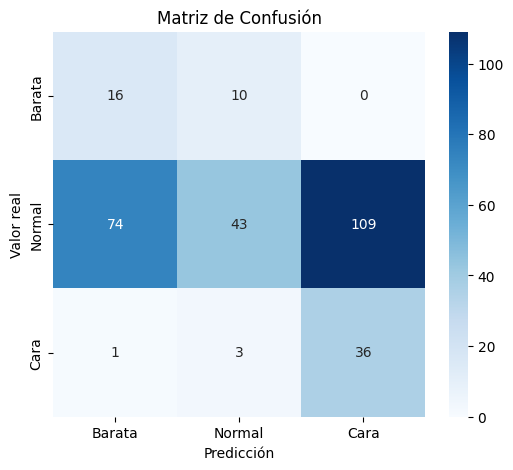

In [8]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=["Barata", "Normal", "Cara"])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Barata", "Normal", "Cara"], yticklabels=["Barata", "Normal", "Cara"])
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión")
plt.show()

En este caso podemos ver un desempeño muy pobre del modelo de clasificación. Viendo las métricas, vemos que accuracy, recall y f1-score tienen valores similares entre 0.3137 y 0.3253. Es importante destacar que el average se colocó como weighted porque estamos trabajando con datos que no siguen una distribución normal. Por esa misma razón, el accuracy no es una métrica muy confiable. Sin embargo recall, que mide la cantidad de veces que se clasificó una casa en donde debería, también es un valor muy bajo. Esto muestra que el modelo falla en detectar muchas de las clasificaciones y solo logra captar bien una categoría. Por otra parte, la precisión es bastante altavde 0.6440. Esto va de la mano con lo que se decía antes de que cuando sí se califica bien una casa, lo hace bastante bien. Si embargo, como ya se mencionó, el f1-score, que es una mezcla entre la predicción y el recall, sigue mostrando un valor bajo, lo que nos lleva a la conclusión de que el modelo no tiene un buen desempeño. La matriz de confusión solo hace más claro el problema mostrando que en las predicciones casi siempre se ponian las casas como "normal", cuando realmente eran de otra categoría. Aún así se logra apreciar que en la variable "Normal" es donde menos cometío errores, lo que concuerda con el análisis anterior.

### Analisis sobreajuste

In [9]:

pipeline = Pipeline([('preprocessor', preprocessor), ('model', GaussianNB())])
pipeline.fit(X_train, y_train)

train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Accuracy en entrenamiento: {train_acc:.4f}")
print(f"Accuracy en prueba: {test_acc:.4f}")

if train_acc > test_acc + 0.1:
    print("El modelo podría estar sobreajustado.")
else:
    print("El modelo no parece sobreajustado.")

train_probs = pipeline.predict_proba(X_train)
test_probs = pipeline.predict_proba(X_test)

train_log_loss = log_loss(y_train, train_probs)
test_log_loss = log_loss(y_test, test_probs)

print(f"Log Loss en entrenamiento: {train_log_loss:.4f}")
print(f"Log Loss en prueba: {test_log_loss:.4f}")

if train_log_loss < test_log_loss:
    print("Posible sobreajuste detectado: el log loss en entrenamiento es menor que en prueba.")


Accuracy en entrenamiento: 0.3724
Accuracy en prueba: 0.3253
El modelo no parece sobreajustado.
Log Loss en entrenamiento: 22.5503
Log Loss en prueba: 24.3171
Posible sobreajuste detectado: el log loss en entrenamiento es menor que en prueba.


### Validacion Cruzada

In [10]:

# Modelo sin validación cruzada
pipeline = Pipeline([('preprocessor', preprocessor), ('model', GaussianNB())])
pipeline.fit(X_train, y_train)

y_pred_simple = pipeline.predict(X_test)
accuracy_simple = accuracy_score(y_test, y_pred_simple)

print(f"Accuracy del modelo sin validación cruzada: {accuracy_simple:.4f}")

# Modelo con validación cruzada
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=5)
accuracy_cv = accuracy_score(y_train, y_pred_cv)

print(f"Accuracy del modelo con validación cruzada: {accuracy_cv:.4f}")

if accuracy_cv > accuracy_simple:
    print("El modelo con validación cruzada tuvo mejor rendimiento.")
else:
    print("El modelo sin validación cruzada tuvo mejor rendimiento.")


Accuracy del modelo sin validación cruzada: 0.3253
Accuracy del modelo con validación cruzada: 0.3690
El modelo con validación cruzada tuvo mejor rendimiento.


### Optimización de hiperparámetros

In [14]:
from sklearn.metrics import recall_score, f1_score

param_grid = {
    'model__var_smoothing': np.logspace(-9, 0, 10)
}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GaussianNB())
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best, average='weighted')
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print(f"Mejor hiperparámetro encontrado: {grid_search.best_params_}")
print(f"Accuracy del mejor modelo en prueba: {accuracy_best:.4f}")
print(f"Recall del mejor modelo en prueba: {recall_best:.4f}")
print(f"F1-score del mejor modelo en prueba: {f1_best:.4f}")

Mejor hiperparámetro encontrado: {'model__var_smoothing': np.float64(1.0)}
Accuracy del mejor modelo en prueba: 0.8116
Recall del mejor modelo en prueba: 0.8116
F1-score del mejor modelo en prueba: 0.8267


El modelo mejoró significativamente después de ajustar el hiperparámetro `var_smoothing` en Naive Bayes. Antes de la optimización, el accuracy del modelo con validación cruzada era aproximadamente 0.3690, mientras que después del ajuste aumentó a 0.8116, lo que indica una mejora notable en la capacidad del modelo para hacer predicciones más precisas.

Además del accuracy, se evaluaron otras métricas importantes para tener una visión más completa del rendimiento del modelo:

- **Recall**: El recall del mejor modelo en la prueba fue de 0.8116, lo que indica que el modelo es capaz de identificar correctamente una alta proporción de los casos positivos. Un alto recall es crucial en aplicaciones donde es importante minimizar los falsos negativos.
- **F1-score**: El F1-score del mejor modelo en la prueba fue de 0.8267, lo que sugiere un buen equilibrio entre precisión y recall. El F1-score es especialmente útil cuando se necesita un balance entre ambos, ya que es la media armónica de la precisión y el recall.

Estas métricas adicionales confirman que el modelo no solo tiene un buen accuracy, sino que también mantiene un buen equilibrio entre precisión y recall, lo que es crucial para aplicaciones donde tanto los falsos positivos como los falsos negativos tienen un impacto significativo. En resumen, el ajuste del hiperparámetro `var_smoothing` ha mejorado significativamente el rendimiento general del modelo, haciéndolo más robusto y confiable para hacer predicciones precisas.

### Comparación con Árbol de Decisión y Random Forest

In [12]:
# Naive Bayes Optimizado
start_time = time.time()
y_pred_nb = best_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average="weighted")
recall_nb = recall_score(y_test, y_pred_nb, average="weighted")
f1_nb = f1_score(y_test, y_pred_nb, average="weighted")
time_nb = time.time() - start_time

# Random Forest
# Tomamos el código de RandomForest de la hoja pasada
columnas_utiles = ["OverallQual", "GrLivArea", "GarageCars", "TotalBsmtSF", "FullBath", "YearBuilt", "LotArea"]
X_rf = df_train[columnas_utiles]
y_rf = df_train["Categoria"]

X_rf = pd.get_dummies(X_rf)

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
start_time = time.time()
rf_model.fit(X_train_rf, y_train_rf)
y_pred_rf = rf_model.predict(X_test_rf)
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
precision_rf = precision_score(y_test_rf, y_pred_rf, average="weighted")
recall_rf = recall_score(y_test_rf, y_pred_rf, average="weighted")
f1_rf = f1_score(y_test_rf, y_pred_rf, average="weighted")
time_rf = time.time() - start_time


Comparación de Modelos:
Naive Bayes - Accuracy: 0.8116, Precision: 0.8770, Recall: 0.8116, F1-score: 0.8267, Tiempo: 0.0174 seg
Random Forest - Accuracy: 0.9041, Precision: 0.9013, Recall: 0.9041, F1-score: 0.8985, Tiempo: 0.1716 seg


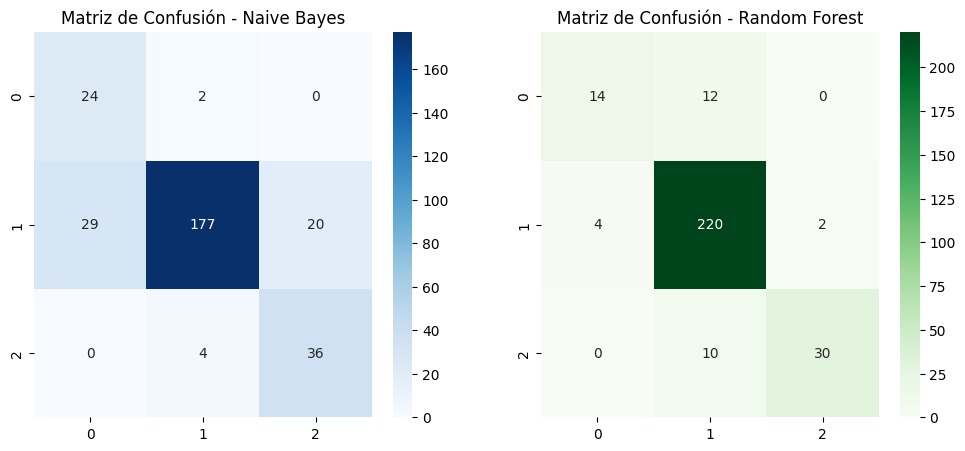

In [13]:
print("\nComparación de Modelos:")
print(f"Naive Bayes - Accuracy: {accuracy_nb:.4f}, Precision: {precision_nb:.4f}, Recall: {recall_nb:.4f}, F1-score: {f1_nb:.4f}, Tiempo: {time_nb:.4f} seg")
print(f"Random Forest - Accuracy: {accuracy_rf:.4f}, Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}, F1-score: {f1_rf:.4f}, Tiempo: {time_rf:.4f} seg")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_nb, labels=["Barata", "Normal", "Cara"]), annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de Confusión - Naive Bayes")

sns.heatmap(confusion_matrix(y_test_rf, y_pred_rf, labels=["Barata", "Normal", "Cara"]), annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Matriz de Confusión - Random Forest")

plt.show()

El modelo de Random Forest es mejor para predecir en comparación con Naive Bayes. Su accuracy es de 0.9041, lo que significa que clasifica correctamente el 90.41% de los ejemplos, mientras que Naive Bayes tiene una accuracy de 0.8116. Además, Random Forest presenta una mayor precisión (0.9013 vs. 0.8770) y un mayor recall (0.9041 vs. 0.8116), lo que indica que el modelo es más confiable tanto para evitar falsos positivos como para detectar correctamente cada categoría.

La matriz de confusión también confirma que Random Forest comete menos errores en la clasificación. Mientras que Naive Bayes tiene 29 errores al clasificar casas de categoría 1 (Normal) como 0 (Barata), Random Forest solo tiene 4 de estos errores. Esto indica que el modelo de Random Forest distingue mejor entre las diferentes clases y tiene un menor sesgo hacia una categoría específica.

El modelo de Random Forest tomó significativamente más tiempo en procesar en comparación con Naive Bayes.

Naive Bayes: 0.0130 segundos
Random Forest: 0.1573 segundos
Esto era esperable, ya que Random Forest es un modelo más complejo que entrena múltiples árboles de decisión en paralelo, lo que lo hace más costoso computacionalmente. En contraste, Naive Bayes es un modelo probabilístico simple que procesa los datos mucho más rápido, pero a costa de una menor precisión.